In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio.v2 as imageio
from scipy.fftpack import fft, fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import solve, solve_triangular, lu
from scipy.sparse.linalg import bicgstab, gmres
from scipy.sparse import spdiags


In [40]:
#+++++++++++++++ 1. Parameters
tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny


In [ ]:
#+++++++++++++++  2. Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)


In [8]:
#+++++++++++++++  3. Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

In [9]:
#+++++++++++++++  4. Return Code from HW 4
# Parameters
m = 64
L = 20
dx = L / m
n = m * m

e0 = np.zeros(n)
e1 = np.ones(n)
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m+1):
    e2[m*j - 1] = 0 
    e4[m*j - 1] = 1

# Adjusted vectors for diagonals
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Construct Matrix a (Laplacian)
diagonals_A = [e1, e1, e5, e2, -4 * e1, e3, e4, e1, e1]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]
A = (spdiags(diagonals_A, offsets_A, n, n) / (dx**2)).toarray()

# Construct Matrix C (Partial derivative with respect to y)
diagonals_B = [e1, -e1, e1, -e1]
offsets_B = [-(n - m),-m, m, (n - m)]
B = (spdiags(diagonals_B, offsets_B, n, n) / (2 * dx)).toarray()

# Construct Matrix b (Partial derivative with respect to x)
diagonals_C = [e5, -e2, e3, -e4]
offsets_C = [-m + 1, -1, 1, m - 1]
C = (spdiags(diagonals_C, offsets_C, n, n) / (2 * dx)).toarray()

A[0, 0] = 2


[[2.50656748e-46 3.58026055e-45 1.88132874e-44 ... 1.89208437e-42
  4.77726141e-42 1.13544652e-41]
 [1.17762859e-43 6.53148935e-43 2.62190920e-42 ... 1.58937979e-40
  3.55965448e-40 7.45948974e-40]
 [4.55107657e-41 1.93051090e-40 6.43755335e-40 ... 2.48800035e-38
  5.07311171e-38 9.70266445e-38]
 ...
 [1.96785570e-38 1.23682004e-37 5.47192450e-37 ... 4.35343960e-35
  1.02081172e-34 2.22043326e-34]
 [6.19028421e-41 5.34108575e-40 2.94073557e-39 ... 3.67770729e-37
  9.42879238e-37 2.22743363e-36]
 [1.60178709e-43 2.00029378e-42 1.41248785e-41 ... 2.80046616e-39
  7.94100447e-39 2.06700961e-38]]
Time to run fft :  0.32108592987060547


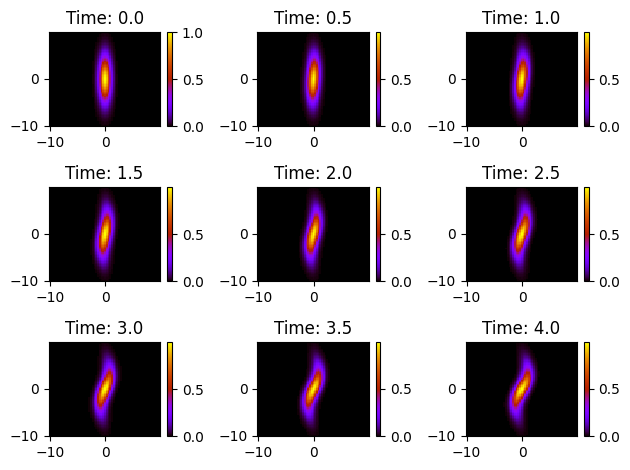

In [44]:
# Two oppositely “charged”, (+) & (-) amplitude.

w1 = (np.exp(-X**2 - ((Y)**2 / 20))).flatten()

# FFT Method

#+++++++++++++++  5. Define the PDE system
def spc_rhs(t, w, nx, ny, K, nu):
    wtc = w.reshape((nx, ny))
    wt = fft2(wtc)
    psit = -wt / K
    psi = np.real(ifft2(psit))
    psi = psi.flatten()
    rhs = nu * np.dot(A, w) - np.dot(B, psi) * np.dot(C, w) + np.dot(C, psi) * np.dot(B, w)
    return rhs

#+++++++++++++++ 6. Solution
start_time = time.time()
wtsol = solve_ivp(spc_rhs, (0, 4), w1, t_eval=tspan, method = 'RK45', args = (nx, ny, K, nu))
# wtsol2 = solve_ivp(spc_rhs, (0, tspan[-1]), w2, t_eval=tspan, method = 'RK45', args = (nx, ny, K, nu))
A1 = wtsol.y
# A1w2 = wtsol2.y
end_time = time.time()

fft_time = end_time - start_time

print(A1)
print("Time to run fft : ", fft_time)

# +++++++++++++++ Plot the solution at each time step
for j, t in enumerate(tspan):
    wtc = A1[:, j].reshape((ny, nx)) 
    # wtc2 = A1w2[:, j].reshape((ny, nx)) 
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, wtc, shading='auto', cmap='gnuplot')
    # plt.pcolor(x, y, wtc2, shading='auto', cmap='gnuplot')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]
Time to run BiCGSTAB :  103.46967935562134


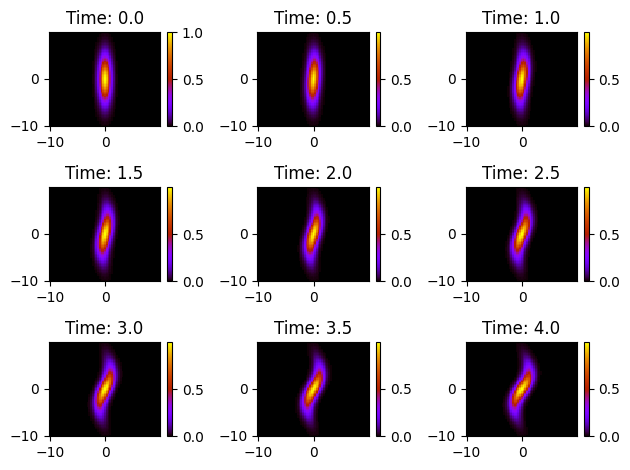

In [20]:
# Direct Solver (Ax/b)


w_ds = (np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs2(t, w_ds, nu, A, B, C):
    psi = solve(A, w_ds)
    rhs2 = nu * np.dot(A, w_ds) - np.dot(B, psi) * np.dot(C, w_ds) + np.dot(C, psi) * np.dot(B, w_ds)
    return rhs2

start_time = time.time()
wtsol_ds = solve_ivp(spc_rhs2, (0, 4), w_ds, t_eval=tspan, method = 'RK45', args = (nu, A, B, C))
A2 = wtsol_ds.y
end_time = time.time()

Ab_time = end_time - start_time

print(A2)
print("Time to run BiCGSTAB : ", Ab_time)

for j, t in enumerate(tspan):
    w_ds = A2[:, j].reshape((ny, nx)) 
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w_ds, shading='auto', cmap='gnuplot')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]
Time to run BiCGSTAB :  1.3871636390686035


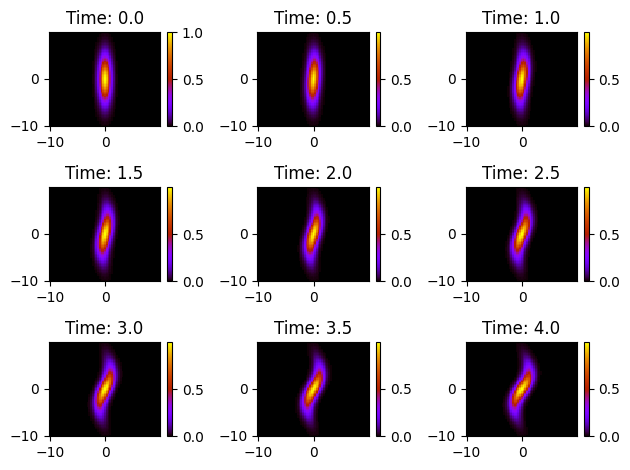

In [21]:
# LU Solver

w_lu = (np.exp(-X**2 - (Y**2)/20)).flatten()

P, L, U = lu(A)

def spc_rhs_lu(t, w_lu, nu, A, B, C, P, L):
    Pw = np.dot(P, w_lu)
    foo = solve_triangular(L, Pw, lower=True)
    psi = solve_triangular(U, foo)
    rhs_lu = nu * np.dot(A, w_lu) - np.dot(B, psi) * np.dot(C, w_lu) + np.dot(C, psi) * np.dot(B, w_lu)
    return rhs_lu

start_time = time.time()
wtsol_lu = solve_ivp(spc_rhs_lu, (0, 4), w_lu, t_eval=tspan, method = 'RK45', args = (nu, A, B, C, P, L))
A3 = wtsol_lu.y
end_time = time.time()

LU_time = end_time - start_time

print(A3)
print("Time to run BiCGSTAB : ", LU_time)

for j, t in enumerate(tspan):
    w_lu = A3[:, j].reshape((ny, nx)) 
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w_lu, shading='auto', cmap='gnuplot')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [23]:
# BiCGSTAB Solver

w_bicgstab = (np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs_bicgstab(t, w_bicgstab, nu, A, B, C):
    psi, _ = bicgstab(A, w_bicgstab, rtol=1e-4)
    return nu * np.dot(A, w_bicgstab) - np.dot(B, psi) * np.dot(C, w_bicgstab) + np.dot(C, psi) * np.dot(B, w_bicgstab)

start_time = time.time()
wtsol_bicgstab = solve_ivp(spc_rhs_bicgstab, (0, 4), w_bicgstab, t_eval=tspan, method='RK45', args=(nu, A, B, C))
A4 = wtsol_bicgstab.y
end_time = time.time()

bicgstab_t = end_time - start_time

print(A4)
print("Time to run BiCGSTAB : ", bicgstab_t)

[[ 2.50656748e-46 -1.36449430e-38  3.59308603e-32 ... -7.69342748e-26
   4.87959645e-26 -3.16244411e-25]
 [ 1.17762859e-43 -5.54436689e-32  6.81645362e-25 ... -2.65296256e-19
   4.85153386e-19 -2.42981555e-19]
 [ 4.55107657e-41 -1.02981172e-31  5.64336388e-25 ... -2.78847495e-20
   6.08114762e-21  1.19515792e-19]
 ...
 [ 1.96785570e-38  3.67951560e-31  1.50178684e-24 ...  6.03485696e-20
  -1.21686377e-19 -6.98193384e-21]
 [ 6.19028421e-41  1.98567901e-31  1.28227800e-25 ...  4.19037686e-20
  -6.81601818e-20 -5.58132995e-20]
 [ 1.60178709e-43  7.64938947e-32 -2.43241533e-25 ...  4.35741864e-20
  -1.06993927e-19 -2.64155267e-19]]
Time to run BiCGSTAB :  46.39096426963806


In [26]:
# GMRES Solver
w_gmres = (np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs_gmres(t, w_gmres, nu, A, B, C):
    psi, _ = gmres(A, w_gmres, rtol=1e-6)
    return nu * np.dot(A, w_gmres) - np.dot(B, psi) * np.dot(C, w_gmres) + np.dot(C, psi) * np.dot(B, w_gmres)

start_time = time.time()
wtsol_gmres = solve_ivp(spc_rhs_gmres, (0, 4), w_gmres, t_eval=tspan, method='RK45', args=(nu, A, B, C))
A5 = wtsol_gmres.y
end_time = time.time()

gmres_t = end_time - start_time

print(A5)
print("Time to run GMRES : ", gmres_t)


[[ 2.50656748e-46 -1.78779365e-36  1.02703489e-36 ... -5.76736523e-26
  -6.68243846e-25  3.02031738e-24]
 [ 1.17762859e-43 -2.26083382e-29  1.85606089e-29 ... -1.48289857e-19
  -7.82375500e-19  1.67439935e-18]
 [ 4.55107657e-41 -4.24645306e-29  3.48706738e-29 ... -2.20138721e-20
  -2.91617797e-19  1.23952676e-18]
 ...
 [ 1.96785570e-38  7.20794382e-28 -6.58740197e-28 ...  4.01632326e-20
   1.34365848e-19 -8.94118327e-19]
 [ 6.19028421e-41  1.69112335e-28 -1.49201092e-28 ...  3.00428335e-20
   1.76000087e-19 -9.80679157e-19]
 [ 1.60178709e-43  5.05816757e-29 -4.38030129e-29 ...  2.47613068e-20
   1.15229047e-20  3.12611310e-20]]
Time to run GMRES :  440.13216948509216


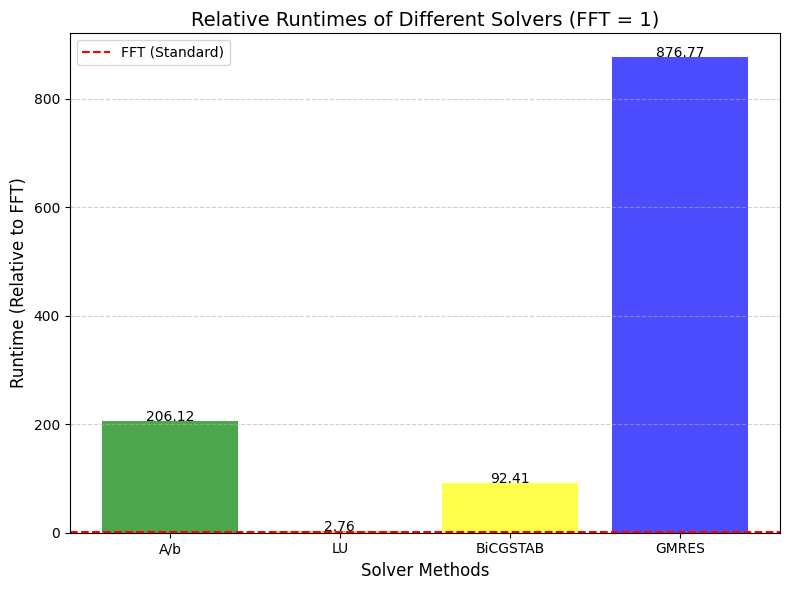

In [33]:
times = [Ab_time / fft_time, LU_time / fft_time, bicgstab_t / fft_time, gmres_t / fft_time]
methods = ['A/b', 'LU', 'BiCGSTAB', 'GMRES']

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['green', 'orange', 'yellow', 'blue'], alpha=0.7)
plt.axhline(y=1, color='red', linestyle='--', label='FFT (Standard)')

# Annotating each bar with its value
for i, val in enumerate(times):
    plt.text(i, val + 0.05, f'{val:.2f}', ha='center', fontsize=10)

# Chart formatting
plt.title('Relative Runtimes of Different Solvers (FFT = 1)', fontsize=14)
plt.ylabel('Runtime (Relative to FFT)', fontsize=12)
plt.xlabel('Solver Methods', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [36]:
# #  +++++++++++++++  Set up The Movie .gif
gif_frames = []

# # Plot the solution at each time step and save frames
for j, t in enumerate(tspan):
    wtc = A1[:, j].reshape((ny, nx)) 
    # wtc2 = A1w2[:, j].reshape((ny, nx)) 
    
    # Create plot
    fig, ax = plt.subplots()
    c = ax.pcolor(x, y, wtc, shading='nearest', cmap='gnuplot')
    fig.colorbar(c)
    ax.set_title(f'Time: {t}')
    
    # Save the current plot as an image frame
    plt.savefig('frame.png')  # Save frame to file
    plt.close(fig)
    
    # Append the frame to gif_frames list
    gif_frames.append(imageio.imread('frame.png'))

# Create the .gif
imageio.mimsave('animation.gif', gif_frames, duration=0.5)  # 0.5 seconds between frames

# Optional: Remove the frame image after gif creation
import os
os.remove('frame.png')

print("GIF created successfully!")

GIF created successfully!
